Importing libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import cv2
import time
from keras import backend as K
from keras import metrics
from sklearn.metrics import f1_score
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from scipy import ndimage

In [3]:
#import pre-processed data
#To reproduce results run this cell
x = np.load('x.npy')
y = np.load('y.npy')

x2 = np.load('x2.npy')
y2 = np.load('y2.npy')

Pre-processing

In [2]:
#processing the dataset
train_csv = pd.read_csv('/notebooks/FER/train.csv')
y = train_csv['emotion'].to_numpy()
x_raw = train_csv['pixels'].to_numpy()

In [4]:
#dictionary with emotion tags
#To reproduce results run this cell

emotion_mapping = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [3]:
def convert_csv_to_np(csv):
    '''Function that takes csv data in an np array form and converts it to usable data. Converts string data to int'''
    
    image_list = []
    
    for image in csv:
        im = np.reshape([int(x) for x in image.split()], (48,48))
        image_list.append(im)
        
    return np.array(image_list)

In [4]:
x = convert_csv_to_np(x_raw)

In [ ]:
#np.save('/notebooks/processed_data/x.npy', x)
#np.save('/notebooks/processed_data/y.npy', y)

In [5]:
#splitting the dataset
#To reproduce results run this cell
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10)

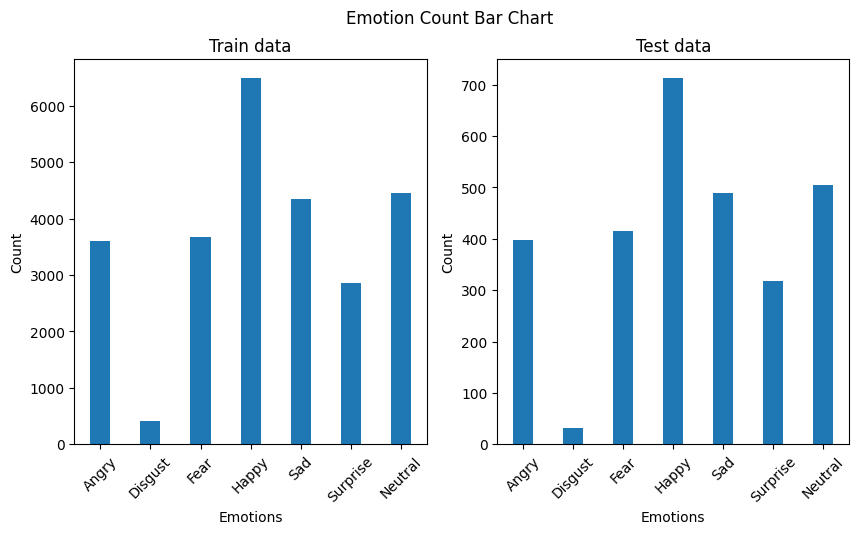

In [5]:
#graphing to show data distrubtion
#To reproduce results run this cell

unique_vals_train, count_train = np.unique(y_train, return_counts = True)

unique_vals_test, count_test = np.unique(y_test, return_counts = True)

emotions = list(emotion_mapping.values())

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))

ax[0].bar(emotions, count_train, width = 0.4)
ax[0].set_xlabel("Emotions")
ax[0].set_ylabel("Count")
ax[0].tick_params('x', labelrotation=45)
ax[0].title.set_text("Train data")

ax[1].bar(emotions, count_test, width = 0.4)
ax[1].set_xlabel("Emotions")
ax[1].set_ylabel("Count")
ax[1].tick_params('x', labelrotation=45)
ax[1].title.set_text("Test data")

fig.suptitle("Emotion Count Bar Chart")

plt.show()

In [8]:
#data augmentation function to even out distribution
def data_aug(emotion_index=1):
    disg_index = np.where(y == emotion_index)
    
    x2 = x
    y2 = y
    
    for index in disg_index[0]:
        img = x[index]
    
        ud_img = np.array([np.flipud(img)])
        x2 = np.concatenate((x2,ud_img))
        y2 = np.append(y2,1)
    
        fliplr_img = np.array([np.fliplr(img)])
        x2 = np.concatenate((x2,fliplr_img))
        y2 = np.append(y2,1)
    
        rot_plus_img = np.array([ndimage.rotate(img, 90)])
        x2 = np.concatenate((x2,rot_plus_img))
        y2 = np.append(y2,1)
    
        rot_neg_img = np.array([ndimage.rotate(img, -90)])
        x2 = np.concatenate((x2,rot_neg_img))
        y2 = np.append(y2,1)
    
        filter_img = np.array([ndimage.uniform_filter(img, size=2)])
        x2 = np.concatenate((x2,filter_img))
        y2 = np.append(y2,1)
        
    return x2,y2
    


In [9]:
#np.save('/notebooks/processed_data/x.npy', x)
#np.save('/notebooks/processed_data/y.npy', y)

(30889, 48, 48)

In [6]:
#splitting data augmented dataset
#To reproduce results run this cell
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.10, random_state=10)

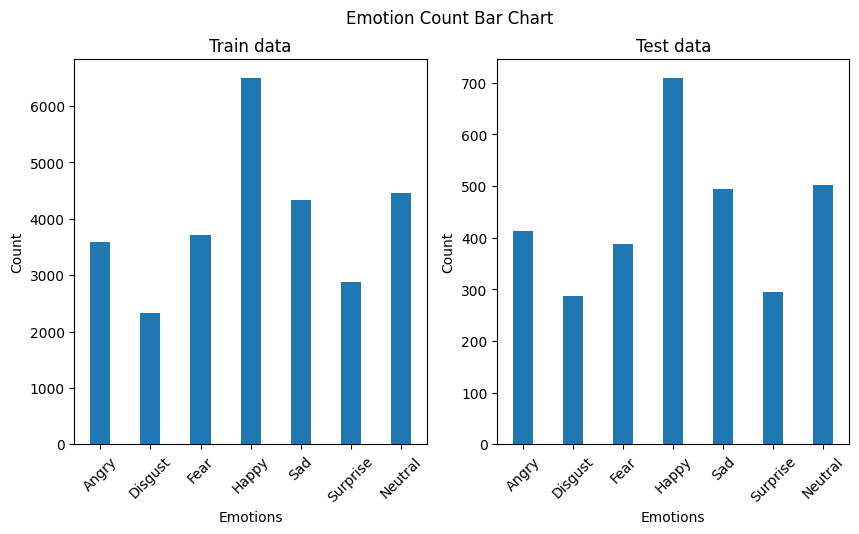

In [7]:
#graphing the newly augmented dataset
unique2_vals_train, count2_train = np.unique(y2_train, return_counts = True)

unique2_vals_test, count2_test = np.unique(y2_test, return_counts = True)

emotions = list(emotion_mapping.values())

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))

ax[0].bar(emotions, count2_train, width = 0.4)
ax[0].set_xlabel("Emotions")
ax[0].set_ylabel("Count")
ax[0].tick_params('x', labelrotation=45)
ax[0].title.set_text("Train data")

ax[1].bar(emotions, count2_test, width = 0.4)
ax[1].set_xlabel("Emotions")
ax[1].set_ylabel("Count")
ax[1].tick_params('x', labelrotation=45)
ax[1].title.set_text("Test data")

fig.suptitle("Emotion Count Bar Chart")

plt.show()

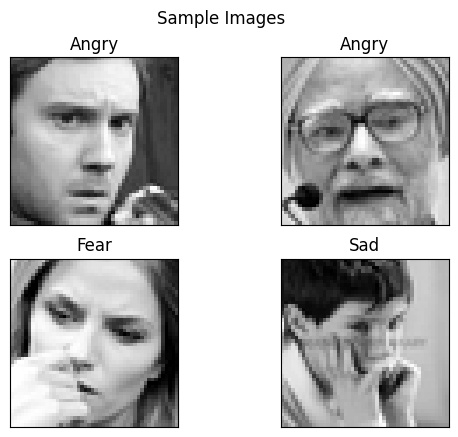

In [10]:
#graphing sample images
#To reproduce results run this cell
fig, ax = plt.subplots(nrows = 2, ncols = 2)

i = 0
for row in ax:
    for col in row:
        col.imshow(x[i], cmap = 'gray')
        col.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
        i += 1
    
ax[0,0].title.set_text('Angry')
ax[0,1].title.set_text('Angry')
ax[1,0].title.set_text('Fear')
ax[1,1].title.set_text('Sad')


fig.suptitle('Sample Images')

plt.show()

Neural Models

In [7]:
#converting to one hot
#To reproduce results run this cell

y2_train_one_hot = tf.one_hot(y2_train, depth=7)
y2_train_one_hot_reshape = tf.reshape(y2_train_one_hot, [27800,1,1,7])

In [8]:
#converting shape of one hot to make it usable with network
#To reproduce results run this cell

y2_test_one_hot = tf.one_hot(y2_test, depth=7)
y2_test_one_hot_reshape = tf.reshape(y2_test_one_hot, [3089,1,1,7])

In [9]:
#metric callbacks for networks
#To reproduce results run this cell

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

VGG16

In [9]:
#building VGG16 network
#To reproduce results run this cell

input_1_vgg = tf.keras.Input(shape=(None, None))

input_2_vgg = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(tf.expand_dims(x, -1)))(input_1_vgg)

input_3_vgg = tf.keras.applications.vgg16.preprocess_input(input_2_vgg)


base_model_vgg = VGG16(weights='imagenet', include_top=False, input_tensor=input_3_vgg)
    
x_vgg = base_model_vgg.output

x_vgg = Dense(1024, activation='relu')(x_vgg)

x_vgg = Dense(512, activation='relu')(x_vgg)

predictions_vgg = Dense(7, activation='softmax')(x_vgg)

for layer in base_model_vgg.layers[11:]:
        layer.trainable = False
        
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)
     
model_vgg.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None)]      0         
                                                                 
 lambda (Lambda)             (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem (S  (None, None, None, 3)    0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, None, None, 3)    0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928  

In [11]:
#compiling VGG16
#To reproduce results run this cell
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_m])

In [12]:
#training the network
#To reproduce results run this cell

start_time_vgg16 = time.time()
history_vgg = model_vgg.fit(x=x2_train, y=y2_train_one_hot_reshape, batch_size=50, epochs=12, validation_split=0.1)
train_time_vgg16 = (time.time()-start_time_vgg16)/60

print(train_time_vgg16)

2023-09-20 22:32:06.762632: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 461168640 exceeds 10% of free system memory.
2023-09-20 22:32:07.361228: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 461168640 exceeds 10% of free system memory.


Epoch 1/12
501/501 [==============================] - ETA: 0s - loss: 1.8744 - accuracy: 0.2666 - f1_m: 0.0374

2023-09-20 22:32:28.475649: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51240960 exceeds 10% of free system memory.
2023-09-20 22:32:28.558079: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51240960 exceeds 10% of free system memory.


501/501 [==============================] - 22s 32ms/step - loss: 1.8744 - accuracy: 0.2666 - f1_m: 0.0374 - val_loss: 1.6376 - val_accuracy: 0.3594 - val_f1_m: 0.1403
Epoch 2/12
501/501 [==============================] - 15s 31ms/step - loss: 1.5063 - accuracy: 0.4213 - f1_m: 0.2913 - val_loss: 1.3700 - val_accuracy: 0.4892 - val_f1_m: 0.3985
Epoch 3/12
501/501 [==============================] - 15s 31ms/step - loss: 1.3114 - accuracy: 0.4994 - f1_m: 0.4134 - val_loss: 1.2479 - val_accuracy: 0.5173 - val_f1_m: 0.4430
Epoch 4/12
501/501 [==============================] - 16s 31ms/step - loss: 1.1992 - accuracy: 0.5395 - f1_m: 0.4696 - val_loss: 1.1913 - val_accuracy: 0.5453 - val_f1_m: 0.4904
Epoch 5/12
501/501 [==============================] - 16s 31ms/step - loss: 1.1209 - accuracy: 0.5738 - f1_m: 0.5120 - val_loss: 1.1515 - val_accuracy: 0.5590 - val_f1_m: 0.5058
Epoch 6/12
501/501 [==============================] - 16s 31ms/step - loss: 1.0455 - accuracy: 0.6003 - f1_m: 0.5525 - va

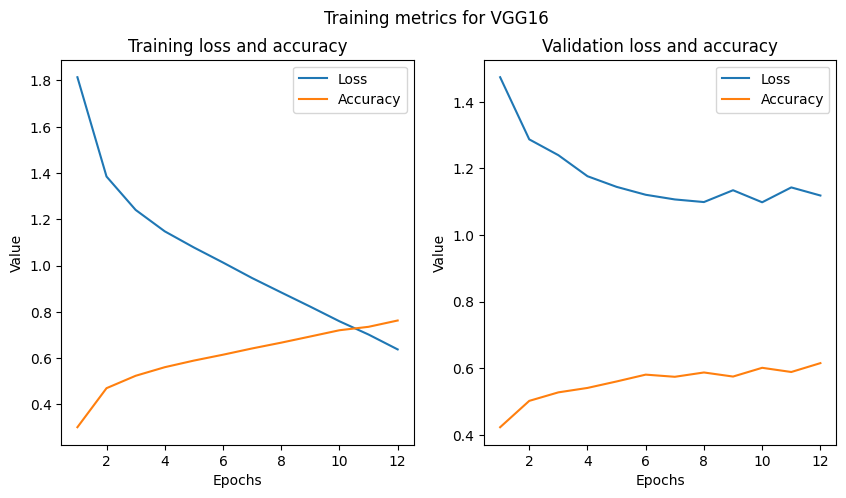

In [66]:
#plotting metrics graph
#To reproduce results run this cell

epochs = [*range(1,13)]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))

ax[0].plot(epochs, history_vgg.history['loss'], label = 'Loss')
ax[0].plot(epochs, history_vgg.history['accuracy'], label = 'Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Value")
ax[0].title.set_text("Training loss and accuracy")
ax[0].legend(loc="upper right")

ax[1].plot(epochs, history_vgg.history['val_loss'], label = 'Loss')
ax[1].plot(epochs, history_vgg.history['val_accuracy'], label = 'Accuracy')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Value")
ax[1].title.set_text("Validation loss and accuracy")
ax[1].legend(loc="upper right")

fig.suptitle("Training metrics for VGG16")

plt.show()

In [29]:
#evaluating the model
#To reproduce results run this cell

model_vgg.evaluate(x=x2_test, y=y2_test_one_hot_reshape)

97/97 [==============================] - 2s 14ms/step - loss: 1.3422 - accuracy: 0.6076 - f1_m: 0.6084


[1.3421614170074463, 0.6076400279998779, 0.6084282398223877]

In [67]:
#saving weights for real time testing

vgg_json = model_vgg.to_json()  
with open("model_data/vgg_v5.json", "w") as json_file:  
    json_file.write(vgg_json)
    
model_vgg.save_weights("model_data/vgg_fine_tuned_v5.h5")

InceptionV3

In [13]:
#Building inceptionv3 network
#To reproduce results run this cell

input_1_v3 = tf.keras.Input(shape=(None, None))

input_2_v3 = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(tf.expand_dims(x, -1)))(input_1_v3)

input_3_v3 = tf.keras.layers.Resizing(75, 75, interpolation = 'bilinear')(input_2_v3)

base_model_v3 = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_3_v3)
    
x_v3 = base_model_v3.output

x_v3 = Dense(1024, activation='relu')(x_v3)

x_v3 = Dense(512, activation='relu')(x_v3)

predictions_v3 = Dense(7, activation='softmax')(x_v3)

for layer in base_model_v3.layers[14:]:
        layer.trainable = False
        
model_v3 = Model(inputs=base_model_v3.input, outputs=predictions_v3)
     
model_v3.summary()

87910968/87910968 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 lambda_1 (Lambda)              (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 resizing (Resizing)            (None, 75, 75, 3)    0           ['lambda_1[0][0]']               
                           

In [14]:
#Compiling inceptionV3 model
#To reproduce results run this cell

model_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_m])

In [15]:
#training network
#To reproduce results run this cell

start_time_v3 = time.time()
history_v3 = model_v3.fit(x=x2_train, y=y2_train_one_hot_reshape, batch_size=50, epochs=15, validation_split=0.1)
train_time_v3 = (time.time()-start_time_v3)/60

print(train_time_v3)

2023-09-20 22:59:39.091841: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 461168640 exceeds 10% of free system memory.


Epoch 1/15
501/501 [==============================] - 29s 47ms/step - loss: 1.6053 - accuracy: 0.3911 - f1_m: 0.2387 - val_loss: 1.4982 - val_accuracy: 0.4349 - val_f1_m: 0.3132
Epoch 2/15
501/501 [==============================] - 19s 39ms/step - loss: 1.4513 - accuracy: 0.4487 - f1_m: 0.3299 - val_loss: 1.4809 - val_accuracy: 0.4385 - val_f1_m: 0.3110
Epoch 3/15
501/501 [==============================] - 20s 39ms/step - loss: 1.3749 - accuracy: 0.4772 - f1_m: 0.3683 - val_loss: 1.4187 - val_accuracy: 0.4612 - val_f1_m: 0.3624
Epoch 4/15
501/501 [==============================] - 20s 39ms/step - loss: 1.3138 - accuracy: 0.4988 - f1_m: 0.4033 - val_loss: 1.3951 - val_accuracy: 0.4601 - val_f1_m: 0.3831
Epoch 5/15
501/501 [==============================] - 20s 39ms/step - loss: 1.2621 - accuracy: 0.5182 - f1_m: 0.4325 - val_loss: 1.4433 - val_accuracy: 0.4406 - val_f1_m: 0.3356
Epoch 6/15
501/501 [==============================] - 20s 40ms/step - loss: 1.2177 - accuracy: 0.5322 - f1_m: 

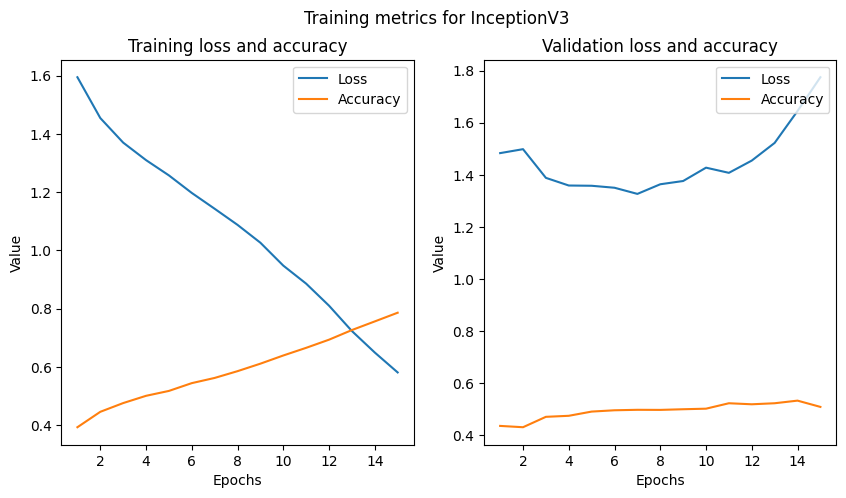

In [22]:
#plotting metrics graph
#To reproduce results run this cell

epochs = [*range(1,16)]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))

ax[0].plot(epochs, history_v3.history['loss'], label = 'Loss')
ax[0].plot(epochs, history_v3.history['accuracy'], label = 'Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Value")
ax[0].title.set_text("Training loss and accuracy")
ax[0].legend(loc="upper right")

ax[1].plot(epochs, history_v3.history['val_loss'], label = 'Loss')
ax[1].plot(epochs, history_v3.history['val_accuracy'], label = 'Accuracy')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Value")
ax[1].title.set_text("Validation loss and accuracy")
ax[1].legend(loc="upper right")

fig.suptitle("Training metrics for InceptionV3")

plt.show()

In [23]:
#evaluating model
#To reproduce results run this cell

model_v3.evaluate(x=x2_test, y=y2_test_one_hot_reshape)

97/97 [==============================] - 2s 21ms/step - loss: 1.8979 - accuracy: 0.4843 - f1_m: 0.4843


[1.8979250192642212, 0.4842991232872009, 0.4842793941497803]

In [24]:
#saving model for real time testing

v3_json = model_v3.to_json()  
with open("model_data/v3_v3.json", "w") as json_file:  
    json_file.write(v3_json)
model_v3.save_weights("model_data/v3_fine_tuned_v3.h5")

VGG19

In [16]:
#Building VGG19 model
#To reproduce results run this cell

input_1_vgg19 = tf.keras.Input(shape=(None, None))

input_2_vgg19 = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(tf.expand_dims(x, -1)))(input_1_vgg19)

base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_tensor=input_2_vgg19)
    
x_vgg19 = base_model_vgg19.output

x_vgg19 = Dense(1024, activation='relu')(x_vgg19)

x_vgg19 = Dense(512, activation='relu')(x_vgg19)

predictions_vgg19 = Dense(7, activation='softmax')(x_vgg19)

for layer in base_model_vgg19.layers[12:]:
        layer.trainable = False
        
model_vgg19 = Model(inputs=base_model_vgg19.input, outputs=predictions_vgg19)
     
model_vgg19.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None)]      0         
                                                                 
 lambda_2 (Lambda)           (None, None, None, 3)     0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                            

In [17]:
#Compiling model
#To reproduce results run this cell

model_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_m])

In [18]:
#training the model
#To reproduce results run this cell

start_time_vgg19 = time.time()
history_vgg19 = model_vgg19.fit(x=x2_train, y=y2_train_one_hot_reshape, batch_size=50, epochs=15, validation_split=0.1)
train_time_vgg19 = (time.time()-start_time_vgg19)/60

print(train_time_vgg19)

Epoch 1/15
501/501 [==============================] - 20s 38ms/step - loss: 2.0034 - accuracy: 0.2335 - f1_m: 0.0019 - val_loss: 1.8624 - val_accuracy: 0.2597 - val_f1_m: 0.0000e+00
Epoch 2/15
501/501 [==============================] - 19s 38ms/step - loss: 1.7643 - accuracy: 0.3107 - f1_m: 0.0681 - val_loss: 1.6835 - val_accuracy: 0.3608 - val_f1_m: 0.1437
Epoch 3/15
501/501 [==============================] - 19s 38ms/step - loss: 1.5844 - accuracy: 0.3928 - f1_m: 0.2450 - val_loss: 1.4737 - val_accuracy: 0.4281 - val_f1_m: 0.3212
Epoch 4/15
501/501 [==============================] - 19s 38ms/step - loss: 1.4050 - accuracy: 0.4630 - f1_m: 0.3612 - val_loss: 1.3446 - val_accuracy: 0.4755 - val_f1_m: 0.4019
Epoch 5/15
501/501 [==============================] - 19s 38ms/step - loss: 1.2900 - accuracy: 0.5055 - f1_m: 0.4171 - val_loss: 1.3028 - val_accuracy: 0.5076 - val_f1_m: 0.4414
Epoch 6/15
501/501 [==============================] - 19s 38ms/step - loss: 1.2012 - accuracy: 0.5402 - f1

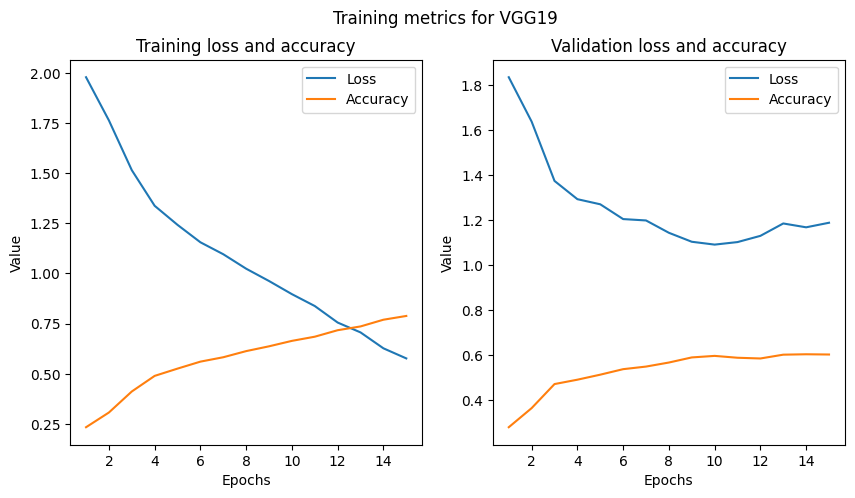

In [36]:
#plotting metrics graph
#To reproduce results run this cell

epochs = [*range(1,16)]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))

ax[0].plot(epochs, history_vgg19.history['loss'], label = 'Loss')
ax[0].plot(epochs, history_vgg19.history['accuracy'], label = 'Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Value")
ax[0].title.set_text("Training loss and accuracy")
ax[0].legend(loc="upper right")

ax[1].plot(epochs, history_vgg19.history['val_loss'], label = 'Loss')
ax[1].plot(epochs, history_vgg19.history['val_accuracy'], label = 'Accuracy')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Value")
ax[1].title.set_text("Validation loss and accuracy")
ax[1].legend(loc="upper right")

fig.suptitle("Training metrics for VGG19")

plt.show()

In [37]:
#evaluating model
#To reproduce results run this cell

model_vgg19.evaluate(x=x2_test, y=y2_test_one_hot_reshape)

97/97 [==============================] - 1s 14ms/step - loss: 1.2252 - accuracy: 0.6015 - f1_m: 0.5963


[1.225223183631897, 0.6014891266822815, 0.5963348150253296]

In [39]:
#saving model for real time testing

vgg_json = model_vgg19.to_json()  
with open("model_data/vgg19_v1.json", "w") as json_file:  
    json_file.write(vgg_json)
    
model_vgg19.save_weights("model_data/vgg19_fine_tuned_v1.h5")

Xception

In [10]:
#building xception model
#To reproduce results run this cell

input_1_xception = tf.keras.Input(shape=(None, None))

input_2_xception = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(tf.expand_dims(x, -1)))(input_1_xception)

input_3_xception = tf.keras.layers.Resizing(75, 75, interpolation = 'bilinear')(input_2_xception)

input_4_xception = tf.keras.applications.xception.preprocess_input(input_3_xception)

base_model_xception = Xception(weights='imagenet', include_top=False, input_tensor=input_4_xception, pooling='avg')
    
x_xception = base_model_xception.output

x_xception = Dense(1024, activation='relu')(x_xception)

x_xception = Dense(512, activation='relu')(x_xception)

predictions_xception = Dense(7, activation='softmax')(x_xception)

#reshaped = tf.keras.layers.Reshape((1,1,7))(predictions_xception)

for layer in base_model_xception.layers[26:]:
        layer.trainable = False
        
model_xception = Model(inputs=base_model_xception.input, outputs=predictions_xception)
     
model_xception.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 lambda (Lambda)                (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 resizing (Resizing)            (None, 75, 75, 3)    0           ['lambda[0][0]']                 
                             

In [11]:
#compiling model
#To reproduce results run this cell

model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_m])

In [13]:
#training model
#To reproduce results run this cell

start_time_xception = time.time()
history_xception = model_xception.fit(x=x2_train, y=y2_train_one_hot, batch_size=50, epochs=8, validation_split=0.1)
train_time_xception = (time.time()-start_time_xception)/60

print(train_time_xception)

2023-09-21 15:23:34.185293: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 461168640 exceeds 10% of free system memory.
2023-09-21 15:23:34.811595: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 461168640 exceeds 10% of free system memory.


Epoch 1/8
501/501 [==============================] - 36s 72ms/step - loss: 0.5812 - accuracy: 0.7836 - f1_m: 0.7786 - val_loss: 1.3053 - val_accuracy: 0.5914 - val_f1_m: 0.5925
Epoch 2/8
501/501 [==============================] - 37s 73ms/step - loss: 0.5089 - accuracy: 0.8090 - f1_m: 0.8058 - val_loss: 1.3240 - val_accuracy: 0.6065 - val_f1_m: 0.6065
Epoch 3/8
501/501 [==============================] - 37s 74ms/step - loss: 0.4698 - accuracy: 0.8237 - f1_m: 0.8203 - val_loss: 1.4103 - val_accuracy: 0.5971 - val_f1_m: 0.5977
Epoch 4/8
501/501 [==============================] - 37s 74ms/step - loss: 0.4134 - accuracy: 0.8450 - f1_m: 0.8453 - val_loss: 1.7082 - val_accuracy: 0.5680 - val_f1_m: 0.5665
Epoch 5/8
501/501 [==============================] - 37s 74ms/step - loss: 0.3702 - accuracy: 0.8641 - f1_m: 0.8627 - val_loss: 1.7587 - val_accuracy: 0.5867 - val_f1_m: 0.5871
Epoch 6/8
501/501 [==============================] - 37s 74ms/step - loss: 0.3416 - accuracy: 0.8740 - f1_m: 0.8744

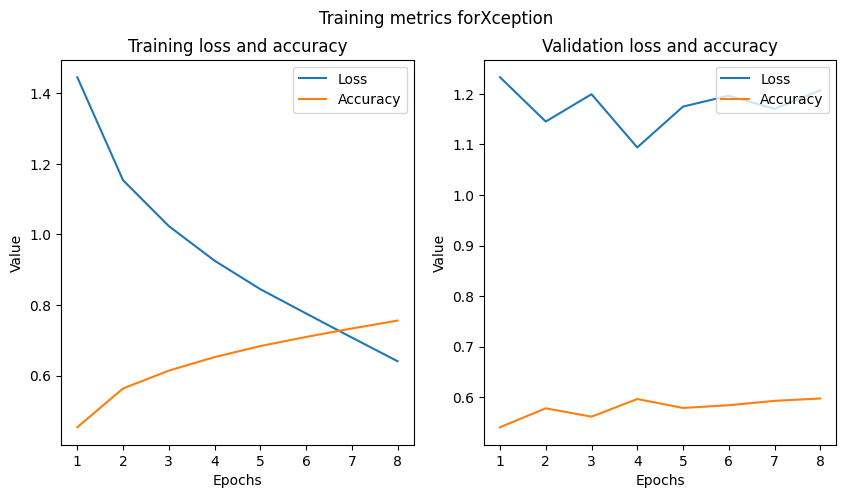

In [59]:
#plotting metrics graphs
#To reproduce results run this cell

epochs = [*range(1,9)]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))

ax[0].plot(epochs, history_xception.history['loss'], label = 'Loss')
ax[0].plot(epochs, history_xception.history['accuracy'], label = 'Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Value")
ax[0].title.set_text("Training loss and accuracy")
ax[0].legend(loc="upper right")

ax[1].plot(epochs, history_xception.history['val_loss'], label = 'Loss')
ax[1].plot(epochs, history_xception.history['val_accuracy'], label = 'Accuracy')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Value")
ax[1].title.set_text("Validation loss and accuracy")
ax[1].legend(loc="upper right")

fig.suptitle("Training metrics for Xception")

plt.show()

In [60]:
#evaluating model
#To reproduce results run this cell

model_xception.evaluate(x=x2_test, y=y2_test_one_hot)

10/97 [==>...........................] - ETA: 1s - loss: 1.2504 - accuracy: 0.5969 - f1_m: 0.5899

2023-08-31 17:30:20.703020: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-31 17:30:20.703095: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


97/97 [==============================] - 2s 19ms/step - loss: 1.2618 - accuracy: 0.5957 - f1_m: 0.5822


2023-08-31 17:30:22.565152: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-31 17:30:22.565239: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


[1.2618162631988525, 0.595661997795105, 0.5822224020957947]

In [62]:
#saving model for real time testing

vgg_json = model_xception.to_json()  
with open("model_data/xception_v1.json", "w") as json_file:  
    json_file.write(vgg_json)
    
model_xception.save_weights("model_data/xception_fine_tuned_v1.h5")